In [129]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

sns.set_style('whitegrid')
%config InlineBackend.figure_formats = ['svg']

# Curve Fitting

Consider a situation where a variable of interest roughly follows some functional form, or seems to be based on an inherent "curve". In this case, there may be a feature-target relationship, or it might just be the target-over-time. Either way, a traditional machine learning model might not be appropriate, and instead we may simply want to model the data by fitting an explicit equation which can be used later. Here, we'll generate some data to illustrate a possible solution.

[SciPy](https://docs.scipy.org/doc/scipy/tutorial/index.html) is a collection of mathematical algorithms and convenience functions built on NumPy, and we're going to use it here to illustrate curve fitting.

## Latent Function

Given a predefined function `func` or $f$, and some range of values $x_i$ in `x_range` (or $\mathbf{x}$), we will generate an array of numbers $\mathbf{y}$ which can be modeled by the following equation:

$$
y_i = f(x_i) + \epsilon
$$

where $\epsilon$ is some random value between $-p \cdot \text{avg}(|\mathbf{y}|)$ and $p \cdot \text{avg}(|\mathbf{y}|)$, and $p$ is s scaling factor for the "perturbation" or *deviation* from the expected value $E[f(x)] = \bar{\mathbf{y}}$. In this way, our function $f$ is actually meant to represent an example of some **latent** (unknown) function that is driving some data we might observe in practice. In other words, we should pretend as if we do not know what $f$ is for this illustration of curve fitting.

In [130]:
def func_to_data(func, x_range=(-100, 100), perturb=1, n=100):
    '''
    Given a function, get data (or plot) for that function between `x_range`
    
    `perturb` is the amount of random jitter to add to function values.
    '''
    x_ = np.linspace(x_range[0], x_range[1], n)
    y_ = func(x_)
    m = np.mean(abs(y_))
    noise = np.random.uniform(-perturb * m, perturb * m, n)
    
    return (x_, y_ + noise)

### Polynomial Fit

A polynomial is of the form:

$$
f(x) = a_kx^k + a_{k-1}x^{k-1} + \cdots + a_1x + a_0
$$

Where $k$ represents the degree. We can define this in a function (as it will be expected from SciPy), with `x` as the first argument, and the coefficients as the following arguments. We'll use[ NumPy's `polyval`](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html) to do the polynomial computation.

In [131]:
# general polynomial form for degree 3
def poly3(x, a_3, a_2, a_1, a_0):
    coeffs = np.array([a_3, a_2, a_1, a_0])
    return np.polyval(coeffs, x)

In [132]:
# ?np.polyval

Suppose we create some data which is based on an underlying polynomial of degree 3 which we "do not know."

$$
\text{unknown}\; f(x) = x^3 - 3x^2
$$

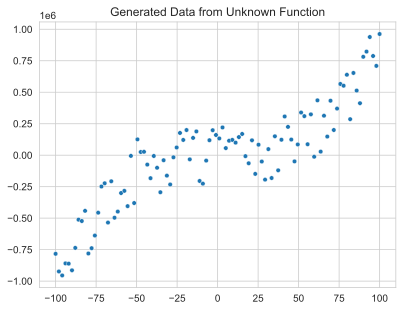

In [133]:
# pretend we do not know this ...
f_poly = lambda x: x ** 3 - 3 * x ** 2

x, y = func_to_data(f_poly)

g = sns.scatterplot(x=x, y=y, s=20)
g.set_title("Generated Data from Unknown Function");

This *looks* like a polynomial of degree 3. So, we can use our general form `poly3` along with the `curve_fit` function to fit to this data and estimate coefficients.

*Note: setting `bounds` speeds up the calculation, and typically improves accuracy.*

In [134]:
# optimal coefficients and their covariance matrix
popt, pcov = curve_fit(poly3, x, y, bounds=(-100, 100))
popt

array([  0.98409935,  -5.38006182, 100.        , 100.        ])

This is not *exactly* right, but it does the job. The first degree is right on, but the rest of the coefficients are off. Likely, within this window, the difference between the two polynomials is negligible.

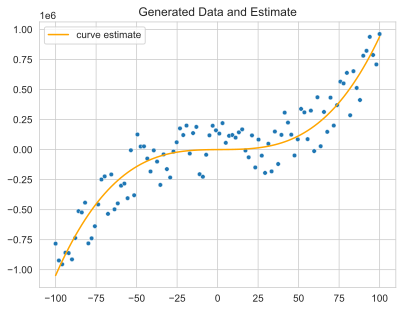

In [135]:
y_pred = np.polyval(popt, x)

g = sns.scatterplot(x=x, y=y, s=20)
g = sns.lineplot(x=x, y=y_pred, label='curve estimate', color='orange')

g.set_title("Generated Data and Estimate");

### Exponential Fit

A general form for the exponential function is:

$$
f(x) = ae^{bx}
$$
 
With coefficients $a$ and $b$.

In [136]:
# general exponential
def exp1(x, a, b):
    return a * np.exp(b * x)

Suppose we create some data which is based on an underlying exponential function which we "do not know."

$$
\text{unknown}\; f(x) = 0.005 e^{0.02 x}
$$

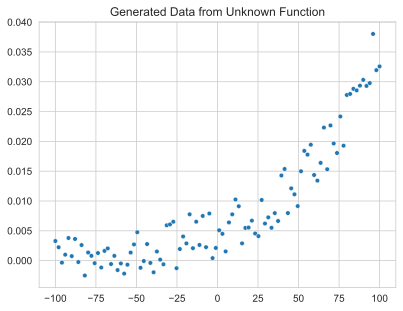

In [137]:
# pretend we do not know this ...
f_exp = lambda x: 0.005 * np.exp(0.02 * x)

x, y = func_to_data(f_exp, perturb=0.5)

g = sns.scatterplot(x=x, y=y, s=20)
g.set_title("Generated Data from Unknown Function");

In [138]:
# optimal coefficients and their covariance matrix
popt, pcov = curve_fit(exp1, x, y, bounds=(-100, 100))
popt

array([0.00455622, 0.02083373])

This is fairly close!

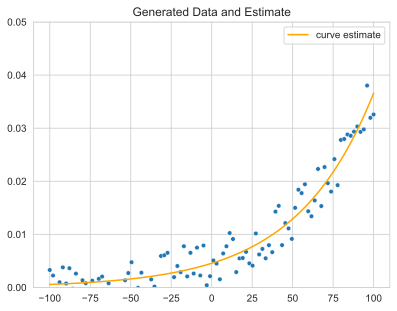

In [139]:
y_pred = popt[0] * np.exp(popt[1] * x)

g = sns.scatterplot(x=x, y=y, s=20)
g = sns.lineplot(x=x, y=y_pred, label='curve estimate', color='orange')

g.set_ylim(0, 0.05)
g.set_title("Generated Data and Estimate");

# Time Series

For the remainder of the lab, you'll need to install [Prophet](https://facebook.github.io/prophet/docs/installation.html#installation-in-python).

To illustrate some of the [**time series functionality of pandas**](https://pandas.pydata.org/docs/user_guide/timeseries.html) (and plotly), we'll use a [dataset](https://github.com/facebook/prophet/blob/main/docs/_docs/quick_start.md#python-api) which contains an approximate **log** of the daily page views of the Peyton Manning page between 2008 and 2016. So, if $y = 8.321$ then the number of page views is $\approx e^{8.321}$.

In [140]:
import pandas as pd
import plotly.express as px

In [141]:
# The number of daily hits on Peyton Manning's Wikipedia page for a few years
url = 'https://raw.githubusercontent.com/facebook/prophet/refs/heads/main/examples/example_wp_log_peyton_manning.csv'
df_manning = pd.read_csv(url)

In [142]:
df_manning.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [143]:
df_manning.rename(columns={'ds': 'date',
                           'y': 'log_hits'},
                  inplace=True)

In [144]:
# Make sure we don't have duplicate dates
df_manning.date.duplicated().sum()

np.int64(0)

## Recognizing Time Series

There are three main components of any time series:

- **Trend:** The *overall* increasing or decreasing
- **Season:** Patterns which repeat indefinitely
    - There can be multiple seasons in a time series
- **Residual:** Noise resulting from natural processes

We define each row of the time series as a **period**. That is, moving from row 1 at time $t=1$ to row 2 at time $t=2$ is equivalent to completing one period. In other words, each row is a period, and <font color='darkred'>periods are **equally spaced** time intervals</font> (see the missing data section below).

In [145]:
# This will make future operations easier
df_manning['date'] = pd.to_datetime(df_manning['date'])
df_manning.set_index('date', inplace=True)
df_manning.sort_index(inplace=True)

In [146]:
px.line(df_manning, template='simple_white')

## Differencing

A **lag** is a previous period. In particular, $\text{lag} = k$ is $k$ periods "ago". We can use `shift` to create columns of data that contain previous lags, and of course you can do analysis on these data as well.

In [147]:
# a positive number is "in the past"
df_manning['log_hits_last_week'] = df_manning.shift(7)

In [148]:
df_manning['log_hits_weekly_delta'] = (df_manning['log_hits'] - 
                                       df_manning['log_hits_last_week'])

In [149]:
df_manning.iloc[:14]

log_hits  log_hits_last_week  log_hits_weekly_delta
date                                                           
2007-12-10  9.590761                 NaN                    NaN
2007-12-11  8.519590                 NaN                    NaN
2007-12-12  8.183677                 NaN                    NaN
2007-12-13  8.072467                 NaN                    NaN
2007-12-14  7.893572                 NaN                    NaN
2007-12-15  7.783641                 NaN                    NaN
2007-12-16  8.414052                 NaN                    NaN
2007-12-17  8.829226            9.590761              -0.761535
2007-12-18  8.382518            8.519590              -0.137072
2007-12-19  8.069655            8.183677              -0.114021
2007-12-20  7.879291            8.072467              -0.193176
2007-12-21  7.761745            7.893572              -0.131827
2007-12-22  7.529406            7.783641              -0.254234
2007-12-23  8.385261            8.414052              -0.028792

In [150]:
df_manning['log_hits_weekly_delta'].describe()

count    2898.000000
mean        0.001045
std         0.597610
min        -4.428490
25%        -0.222085
50%        -0.008786
75%         0.233395
max         3.524829
Name: log_hits_weekly_delta, dtype: float64

So, on average, it looks like the difference in $\log(\texttt{hits})$ between one day and the same day a week prior tends to be positive.

# Smoothing

Time series data is often very difficult to read, especially with highly periodic data. One of the first things we can do to make time series look clearer is "smooth" the data by incrementally consolidating multiple datapoints in windows. In general, when we apply smoothing, we assign each data point a moving window (sometimes called a "filter"). For each window, we aggregate some value (such as the mean) of the data within the window, then we replace each data point with the newly calculated value. It helps us detect patterns and capture trends that might otherwise go unnoticed.

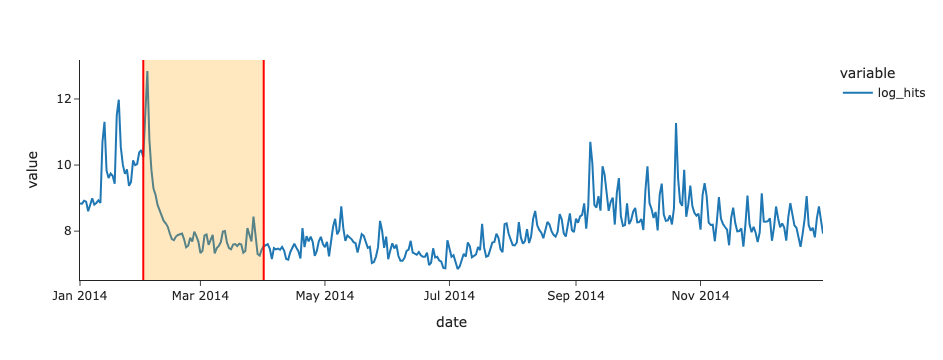

In [151]:
mask = df_manning.index.year == 2014

window = ("2014-02-01", "2014-04-01")

fig = px.line(df_manning[mask]['log_hits'], template='simple_white')

fig.add_vrect(x0=window[0], x1=window[1], 
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_vline(x=window[0], line_color='red', line_width=2, opacity=1)
fig.add_vline(x=window[1], line_color='red', line_width=2, opacity=1)
fig

## Rolling Average

With a rolling average, we first select a *rolling* window size, $w$. Starting at $t=w$, each value is replaced with the average of the previous $w$ data points. Here, we use `.rolling` in pandas with a window size of width **30 days**.

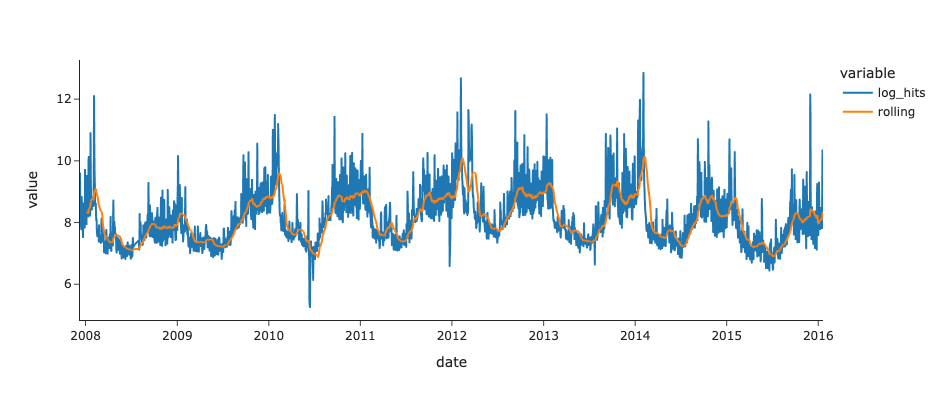

In [156]:
df_plot = df_manning.copy()
df_plot['rolling'] = df_plot.log_hits.rolling(30).mean()

px.line(df_plot[['log_hits', 'rolling']], template='simple_white', height=400)

## Aggregating Periods

Alternatively, we could select a time [offset in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) based on the calendar, and change the period of the data to something using [resampling](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling). In a way, our "window" is a static calendar offset (e.g., each week), and our aggregation happens within that range.

Here we'll choose weekly `W`, and the end of the month `'ME'` (for **m**onth **e**nd), and assign our calculation (i.e., the mean) to each.

In [159]:
# With datetime index, we can "resample" a time series within each week or month, say
df_manning_ = df_manning.reset_index()
df_manning_['window'] = 'original'

df_manning_weekly = df_manning.log_hits.resample('W').mean().reset_index()
df_manning_weekly['window'] = 'week'

df_manning_monthly = df_manning.log_hits.resample('ME').mean().reset_index()
df_manning_monthly['window'] = 'month'

df_plot = pd.concat([df_manning_, df_manning_weekly, df_manning_monthly])

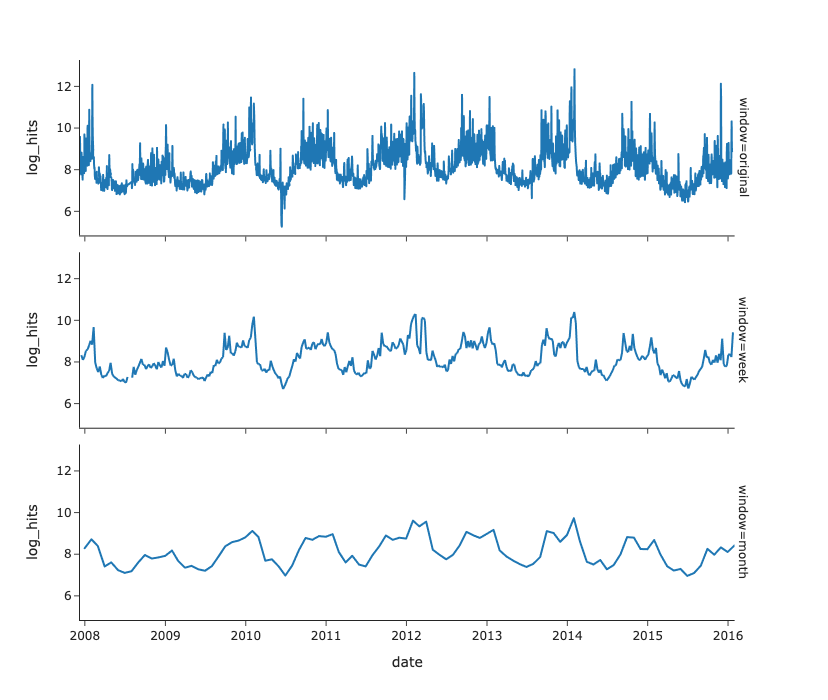

In [164]:
px.line(df_plot, x='date', y='log_hits', facet_row='window', template='simple_white', height=700)

## LO(W)ESS Smoothing

Locally Weighted Scatterplot Smoothing or Locally Estimated Scatterplot Smoothing fits a *weighted* linear model for the data within each window, weighing points by their distance from the center. The resulting curve is one which retains the slope of each of the fit lines at each point. LOWESS technically fits *several* different models (one for each window), and **it was intended to visualize trends in scatterplot data**, which distinguishes it from curve-fitting, above.

*Note: In fact, this is just one of [many smoothing methods in Plotly](https://plotly.com/python/linear-fits/), including the rolling average.*

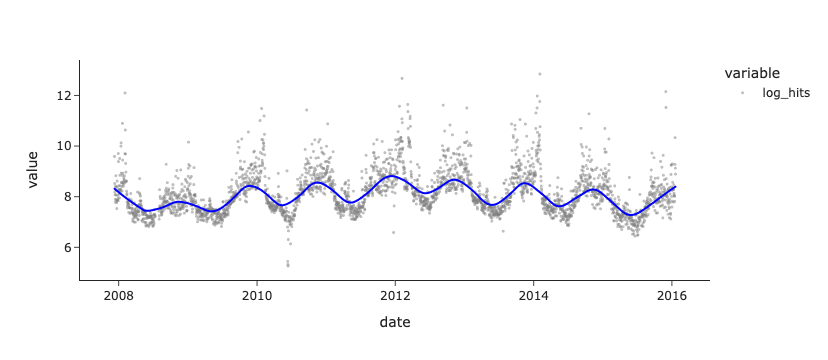

In [169]:
g = px.scatter(df_manning['log_hits'], template='simple_white', opacity=0.5, 
               color_discrete_sequence=['gray'],
               trendline="lowess", trendline_color_override='blue',
               trendline_options=dict(frac=0.1))  # adjust the window here

g.update_traces(marker={'size': 3})
g.update_layout()

## Interpolation

This makes a lot more sense if we are missing some values ...

In [87]:
# take the small subset of data at the beginning of 2016
df_manning_sample = df_manning[df_manning.index.year >= 2016].copy()

# Suppose we're missing some random data
df_missing = df_manning_sample['log_hits'].sample(frac=0.5)
df_missing.sort_index()

date
2016-01-01    7.589336
2016-01-02    7.825245
2016-01-03    8.249314
2016-01-04    9.295141
2016-01-07    8.295798
2016-01-08    8.290293
2016-01-10    8.281724
2016-01-11    8.470730
2016-01-15    8.021913
2016-01-19    9.125871
Name: log_hits, dtype: float64

Here, we use `resample` to fill the implicit gaps in our index, and set those missing values to `NaN`.

In [88]:
df_missing = df_missing.resample('D').mean()
df_missing

date
2016-01-01    7.589336
2016-01-02    7.825245
2016-01-03    8.249314
2016-01-04    9.295141
2016-01-05         NaN
2016-01-06         NaN
2016-01-07    8.295798
2016-01-08    8.290293
2016-01-09         NaN
2016-01-10    8.281724
2016-01-11    8.470730
2016-01-12         NaN
2016-01-13         NaN
2016-01-14         NaN
2016-01-15    8.021913
2016-01-16         NaN
2016-01-17         NaN
2016-01-18         NaN
2016-01-19    9.125871
Freq: D, Name: log_hits, dtype: float64

In [170]:
# use pandas interpolate function to fill the missing values
df_interp = df_missing.interpolate(method='linear')  # Try 'linear'

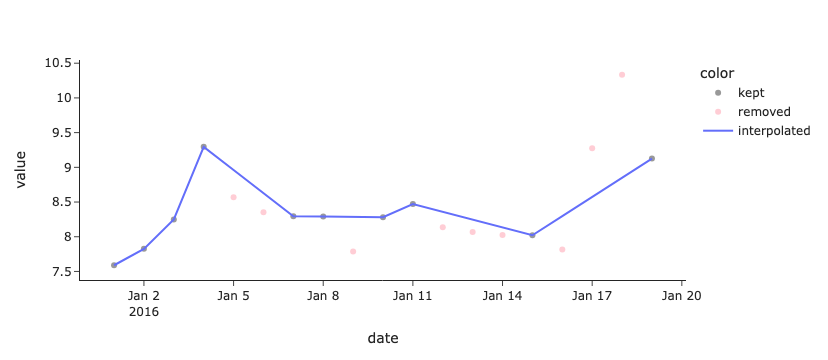

In [171]:
g_1 = px.scatter(df_manning_sample['log_hits'][df_missing.index], 
                 template='simple_white', opacity=0.8, 
                  color=df_missing.isna().replace({True: 'removed', False: 'kept'}),
                  color_discrete_sequence=['gray', 'pink'])

g_2 = px.line(df_interp).data[0]
g_2.name = 'interpolated'

g_1.add_trace(g_2)

All the (missing) pink points would be replaced by the values on the blue line.

# Facebook Prophet

*This walkthrough is a slightly more in depth rendition of the [tutorial](https://facebook.github.io/prophet/docs/quick_start.html) on Facebook Prophet's documentation.*

Prophet is specifically designed for natural time series, i.e., where words like “weekly”, “quarterly”, and “annually” make sense. In particular:

- Holidays are a major factor in how the trend progresses
- Trends are not constant, i.e., they may shift
- Prophet may not perform well in non-traditional settings
    - E.g., imagine a series based on the lifetime events of an amoeba or bacteria

In [105]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

## Data

In [172]:
# This is the same data as above, but we need it in its raw form now
url = 'https://raw.githubusercontent.com/facebook/prophet/refs/heads/main/examples/example_wp_log_peyton_manning.csv'
df = pd.read_csv(url)
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [173]:
df.shape

(2905, 2)

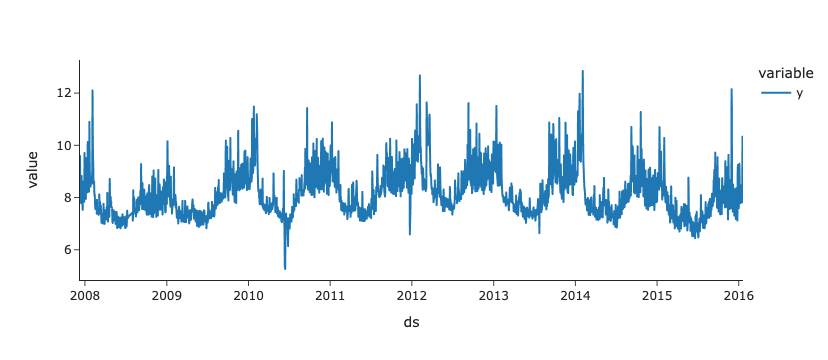

In [174]:
px.line(df.set_index('ds'), template='simple_white')

This DataFrame is formatted especially for Facebook Prophet. I.e., **the input for a Prophet model is always a Pandas DataFrame with two columns: `ds` (datestamp), and `y` (the series).** To incorporate more (exogenous) features into your model, you need to either ensemble multiple Prophet models (a topic for another class), or create a column which is a combination of multiple features (e.g., multiply each column by some weight, and calculate the sum). Either way, time is usually more than sufficient to model a univariate time series (like the one above). Any more features will only incrementally improve the model, but it will also complicate interpretation.

*Note: We'll continue to also use the `df_manning` data frame from above for plotting, since they are formatted slightly differently for different reasons.*

## Components

Prophet is a variant of the [Generalized Additive Model (GAM)](https://en.wikipedia.org/wiki/Generalized_additive_model). In this case, **time is the only regressor** (or, feature), but it is applied through 3 functions:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon(t)
$$

Where:
- $y(t)$ is the value of the time series at time $t$
- $g(t)$ is the **trend** contribution at time $t$
- $s(t)$ is the **seasonality** contribution at time $t$
- $h(t)$ is the **holiday** effect at time $t$
- $\varepsilon(t)$ is random noise, estimated for time $t$

According to the Prophet team:

<font color='darkblue'>*"We are, in effect, framing the forecasting problem as a **curve-fitting** exercise, which is inherently different from time series models that explicitly account for the temporal dependence structure in the data."*</font>

Here, we'll illustrate the typical Prophet model workflow by using default parameters. **If you plan to tailor the model further to your use case, refer to the [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html).** It is very accessible, and highly recommended.

### Trend

In Prophet, **trend** is modeled as a piecewise linear function, broken up by “change points” where the slope of the trend line changes. For example, we can use LOWESS to visualize the slight change in trend in our Peyton Manning data.

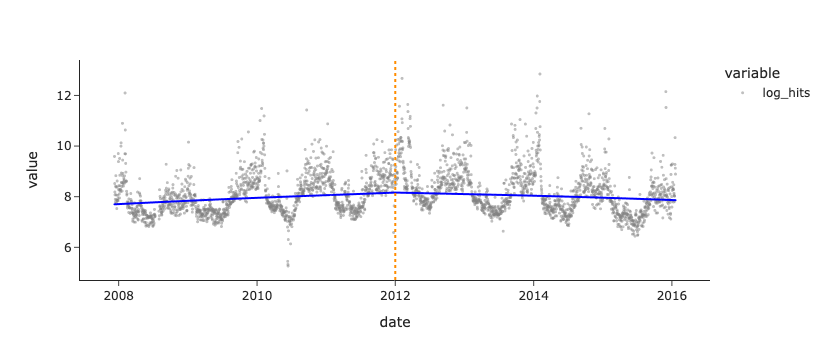

In [108]:
g = px.scatter(df_manning['log_hits'], template='simple_white', opacity=0.5, color_discrete_sequence=['gray'],
               trendline="lowess", trendline_options=dict(frac=1), trendline_color_override='blue')

g.add_vline(x='2012-01-01', line_width=2, line_color="darkorange", line_dash='dot', opacity=1)

g.update_traces(marker={'size': 3})
g.update_layout()

The orange line here would represent a "change point", and to the left side of the orange line would have one trend function, and the right would have another.

- Change points may be obvious
- By default, the Prophet model infers their frequency using a [Laplacian](https://en.wikipedia.org/wiki/Laplace_distribution) prior distribution with parameter $\tau$ and mean of 0.
    - As $\tau$ goes to zero, we get fewer change points (more like a linear model)
    - As $\tau$ increases, we allow for more change points (can get unstable …)
    - In practice, $\tau$ is represented as `changepoint_prior_scale`
- We can also define these manually (e.g., product launches, etc.)

\* *The Laplacian distribution models the difference between two independent exponential distributions.*

### Seasonality

- [Fourier Transformations](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/) are used to capture seasons.
- Prophet aims to capture low-level frequency seasons with [Partial Fourier Sums](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg)
    - We can adjust the order of the partial sum (e.g., `monthly_seasonality=10`)
    - Smaller orders (`_seasonality` values) translate to smoother seasonal models
- Each season gets a random (smoothed) weight
- Decreasing `seasonality_prior_scale` translates to smoother seasonality

### Holidays

- Holidays are very irregular, so they are captured as **dummy variables**
- Prophet accepts a DataFrame of holidays, each with different dates
    - The day(s) around a holiday may also be defined as holidays
    - The effect to the model may be different for different holidays
- A la seasons, holidays will get random weight in the model
    - Decreasing `holiday_prior_scale` translates to a smoother holiday model

## Modeling

In [179]:
model = Prophet(daily_seasonality=False)  # this data is daily

In [180]:
# What options does Prophet provide? 
?Prophet

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    scaling: str = 'absmax',
    holidays_mode=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
    flat trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changep

In [181]:
model.fit(df)

16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:03:44 - cmdstanpy - INFO - Chain [1] done processing


In [182]:
# select the number of periods (in this case, days) to forecast
df_future = model.make_future_dataframe(periods=365)
df_future.shape

(3270, 1)

In [183]:
type(df_future)

pandas.core.frame.DataFrame

In [184]:
df_future.shape[0] - df.shape[0]

365

In [185]:
df.tail()

ds          y
2900  2016-01-16   7.817223
2901  2016-01-17   9.273878
2902  2016-01-18  10.333775
2903  2016-01-19   9.125871
2904  2016-01-20   8.891374

In [186]:
df_future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

`df_future` stores the dates for which we can forecast. We now use the model to make predictions for these days.

In [187]:
df_forecast = model.predict(df_future)

In [189]:
df_forecast.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3265 2017-01-15  7.185960    7.441790    8.918747     6.823736     7.527434   
3266 2017-01-16  7.184929    7.747687    9.289612     6.820372     7.527980   
3267 2017-01-17  7.183899    7.564069    9.051119     6.817957     7.528525   
3268 2017-01-18  7.182869    7.406180    8.851309     6.815684     7.530424   
3269 2017-01-19  7.181838    7.446567    8.940756     6.813412     7.530337   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
3265        1.018279              1.018279              1.018279  0.048295   
3266        1.344302              1.344302              1.344302  0.352291   
3267        1.132712              1.132712              1.132712  0.119618   
3268        0.966375              0.966375              0.966375 -0.066658   
3269        0.979304              0.979304              0.979304 -0.072277   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
3265      0.048295      0.048295  0.969984      0.969984      0.969984   
3266      0.352291      0.352291  0.992010      0.992010      0.992010   
3267      0.119618      0.119618  1.013095      1.013095      1.013095   
3268     -0.066658     -0.066658  1.033033      1.033033      1.033033   
3269     -0.072277     -0.072277  1.051581      1.051581      1.051581   

      multiplicative_terms  multiplicative_terms_lower  \
3265                   0.0                         0.0   
3266                   0.0                         0.0   
3267                   0.0                         0.0   
3268                   0.0                         0.0   
3269                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
3265                         0.0  8.204239  
3266                         0.0  8.529231  
3267                         0.0  8.316611  
3268                         0.0  8.149244  
3269                         0.0  8.161142

In [120]:
df_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

`df_forecast` is essentially a decomposition of our original trend and forecast, through Prophet. We can use this DataFrame to plot (and evaluate) the forecast.

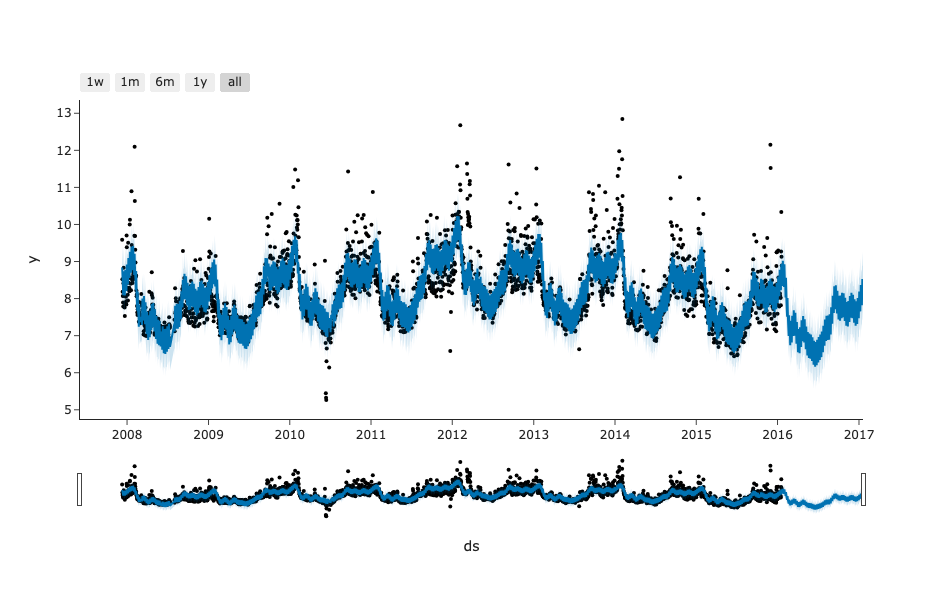

In [71]:
fig = plot_plotly(model, df_forecast, figsize=(800, 600))
fig.update_layout(template='simple_white')

Second, we can plot a decomposition of this trend by plotting the `components`.

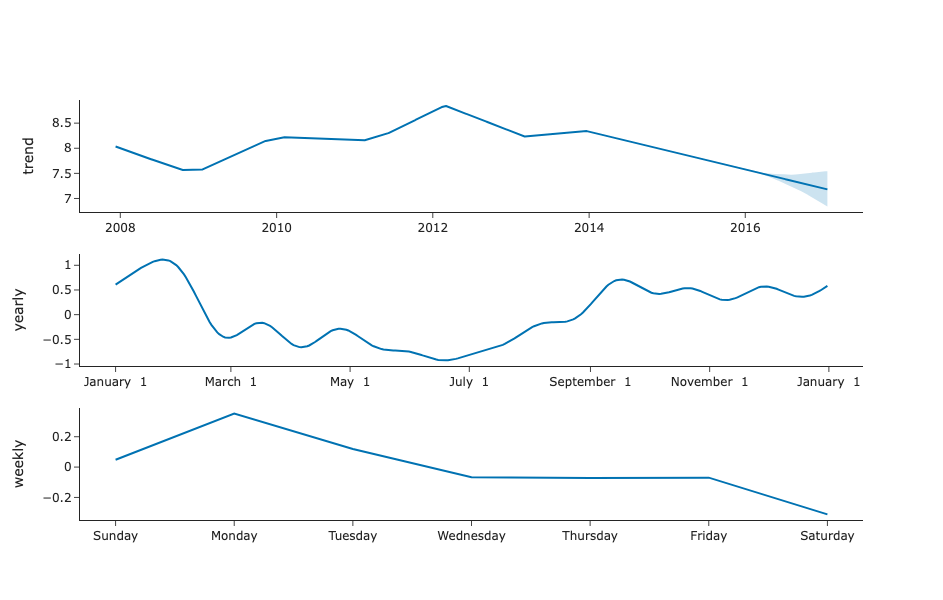

In [121]:
fig = plot_components_plotly(model, df_forecast, figsize=(800, 200))
fig.update_layout(template='simple_white')

We can use this plot to make changes to the original model if you like. E.g., maybe you want to reduce the number of trend change points by updating `n_changepoints` or the `changepoint_prior_scale`.

### A Few Notes on Forecasts

Forecasts are generated by sampling past trend shifts from the calculated change points (i.e., trend shifts). This simulates what future trend shifts might occur. In other words,

**We assume *"the future will see the same average frequency and magnitude of rate changes that were seen [in history]."*** 

This is a pretty biased assumption, so:

* Uncertainty intervals:
  - will not exactly match reality
  - help us detect over-fitting; they are not confidence intervales
* Higher `changepoint_prior_scale` means higher flexibility in fitting, **but**
* Higher `changepoint_prior_scale` *also* means wider uncertainty regions and more overfitting

The further into the future you go, the more uncertainty there is in the trend change, so you can expect a wider region of unknown trend (from the distribution of trends seen).

## Saving and Loading Prophet Models

We can save Python models using JSON [serialization](https://learnpython.com/blog/object-serialization-in-python/).

In [122]:
from prophet.serialize import model_to_json, model_from_json

with open('./model.json', 'w') as f:
    f.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as f:
#     m = model_from_json(f.read())  # Load model

# Explore

Test your understanding of this week's content with the following explorations.

*Note: unless otherwise noted, **explorations are completely optional and will not be reviewed.***

## Exploration 1

Using the examples at the beginning of this lab, generate some data that follows a logarithmic pattern, then plot the generated data. Fit a curve to this data using `curve_fit`.

## Exploration 2

Take a look at the Prophet documentation for [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html) or for [seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html). Based on what you see, pick 2-3 hyperparameters of the `model = Prophet(...)` instantiation to make adjustments to. Try *extremely* different values, and write a few sentences about what the changes do to the model (i.e., for each hyperparameter change, hold the others constant).